In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn

In [2]:
data_dir = '../../data/raw/cifar-10'

In [3]:
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name,label) for name,label in tokens))
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
labels

{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

将数据集划分为训练集、验证集和测试集。这里演示所以是copy操作,正常会用cut操作

In [4]:
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)


def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

在预测期间整理测试集,方便读取

In [5]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file), 
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

调用前面定义的函数

In [6]:
def reorg_cifar10_data(data_dir, valid_radio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_radio)
    reorg_test(data_dir)
    
batch_size = 128
valid_radio = 0.1
reorg_cifar10_data(data_dir, valid_radio)

图像增强

In [7]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, 
                                             scale=(0.64,1.0), 
                                             ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])  

读取由原始图像组成的数据集

In [8]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']
]

指定上面定义的所有图像做数据增强

In [9]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset,
        batch_size, 
        shuffle=True, 
        drop_last=True
        ) for dataset in (train_ds, train_valid_ds)
]

valid_iter = torch.utils.data.DataLoader(
    valid_ds, batch_size, shuffle=False, drop_last=True
)

test_iter = torch.utils.data.DataLoader(
    test_ds, batch_size, shuffle=False, drop_last=False
)

模型

使用torchvision定义的resnet18模型

TODO 手动实现ResNet-18

In [10]:
from torchvision.models import resnet18

def get_net():
    num_classes = 10
    # 加载预定义的 ResNet-18 模型
    net = resnet18(pretrained=False)  # pretrained=False 表示不加载预训练权重
    # 修改最后一层全连接层以适应我们的类别数
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

训练函数

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, step_size=lr_period, gamma=lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from time import time
from tqdm import tqdm  # 进度条（可选）
import matplotlib.pyplot as plt

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 初始化优化器和学习率调度器
    trainer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(trainer, step_size=lr_period, gamma=lr_decay)
    
    # 多 GPU 并行（如果可用）
    if len(devices) > 1:
        net = nn.DataParallel(net, device_ids=devices)
    net.to(devices[0])

    # 记录训练过程
    train_loss, train_acc, val_acc = [], [], []
    plt.figure(figsize=(8, 4))

    # 计时器
    start_time = time()
    
    for epoch in range(num_epochs):
        net.train()  # 训练模式
        epoch_loss, epoch_acc, total_samples = 0.0, 0.0, 0

        # 使用 tqdm 显示进度条（可选）
        for features, labels in tqdm(train_iter, desc=f'Epoch {epoch+1}/{num_epochs}'):
            features, labels = features.to(devices[0]), labels.to(devices[0])
            
            # 前向计算
            outputs = net(features)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            # 反向传播
            trainer.zero_grad()
            loss.backward()
            trainer.step()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            # 累积统计量
            batch_size = labels.size(0)
            epoch_loss += loss.item() * batch_size
            epoch_acc += correct
            total_samples += batch_size

        # 计算平均损失和准确率
        avg_loss = epoch_loss / total_samples
        avg_acc = epoch_acc / total_samples
        train_loss.append(avg_loss)
        train_acc.append(avg_acc)
        
        # 验证集评估
        if valid_iter is not None:
            net.eval()  # 评估模式
            correct, total = 0, 0
            with torch.no_grad():
                for features, labels in valid_iter:
                    features, labels = features.to(devices[0]), labels.to(devices[0])
                    outputs = net(features)
                    _, predicted = torch.max(outputs.data, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            val_accuracy = correct / total
            val_acc.append(val_accuracy)
        
        # 更新学习率
        scheduler.step()

        # 打印日志
        log = f'Epoch {epoch+1}/{num_epochs}: train loss={avg_loss:.3f}, train acc={avg_acc:.3f}'
        if valid_iter is not None:
            log += f', valid acc={val_accuracy:.3f}'
        print(log)

        # 动态绘制曲线（替代 d2l.Animator）
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='train loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label='train acc')
        if valid_iter is not None:
            plt.plot(val_acc, label='valid acc')
        plt.xlabel('epoch')
        plt.legend()
        plt.pause(0.1)  # 动态更新

    # 计算吞吐量
    total_time = time() - start_time
    total_samples = len(train_iter.dataset) * num_epochs
    throughput = total_samples / total_time
    print(f'{throughput:.1f} examples/sec on {devices}')

/home/bcy/miniconda3/envs/dl_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bcy/miniconda3/envs/dl_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 351/351 [00:58<00:00,  5.95it/s]


Epoch 1/20: train loss=2.028, train acc=0.261, valid acc=0.107


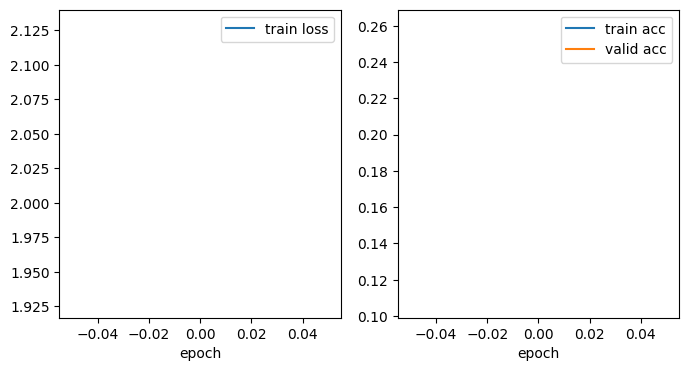

Epoch 2/20: 100%|██████████| 351/351 [00:30<00:00, 11.40it/s]


Epoch 2/20: train loss=1.681, train acc=0.381, valid acc=0.108


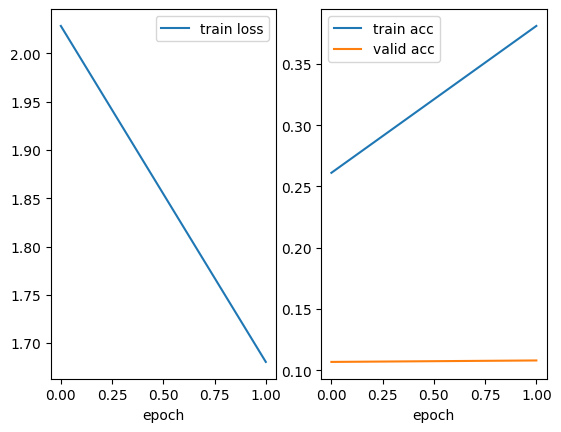

Epoch 3/20: 100%|██████████| 351/351 [00:30<00:00, 11.36it/s]


Epoch 3/20: train loss=1.553, train acc=0.430, valid acc=0.117


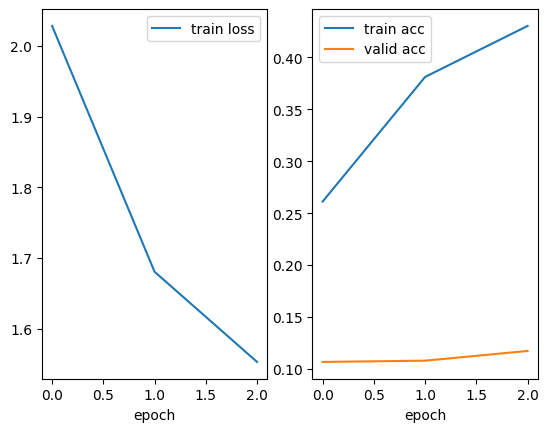

Epoch 4/20: 100%|██████████| 351/351 [00:30<00:00, 11.33it/s]


Epoch 4/20: train loss=1.476, train acc=0.461, valid acc=0.115


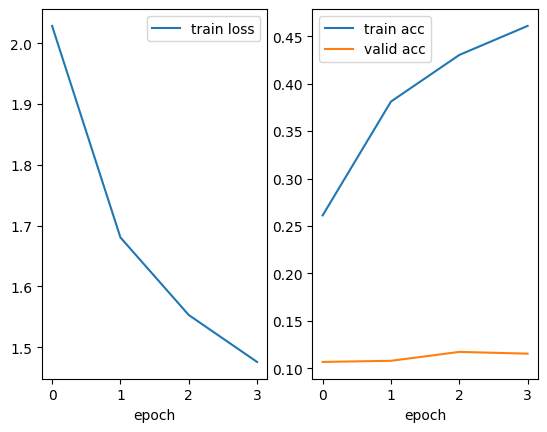

Epoch 5/20: 100%|██████████| 351/351 [00:31<00:00, 11.31it/s]


Epoch 5/20: train loss=1.424, train acc=0.482, valid acc=0.123


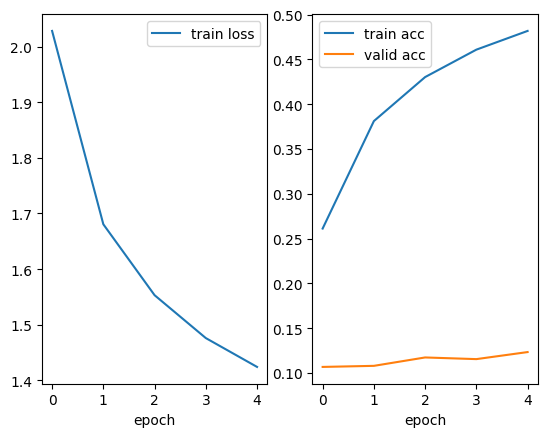

Epoch 6/20: 100%|██████████| 351/351 [00:31<00:00, 11.25it/s]


Epoch 6/20: train loss=1.374, train acc=0.502, valid acc=0.111


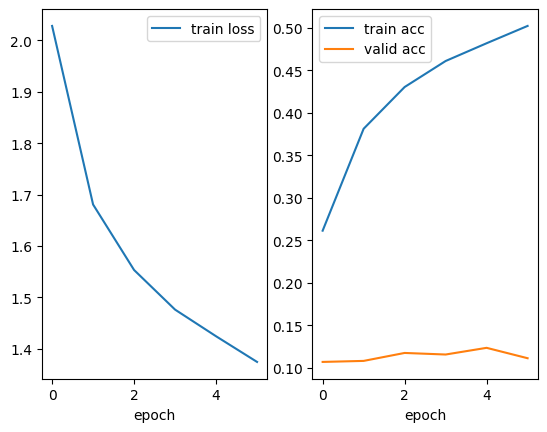

Epoch 7/20: 100%|██████████| 351/351 [00:31<00:00, 11.22it/s]


Epoch 7/20: train loss=1.341, train acc=0.517, valid acc=0.108


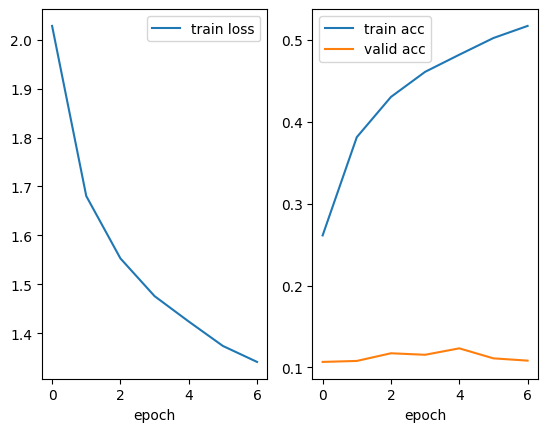

Epoch 8/20: 100%|██████████| 351/351 [00:31<00:00, 11.21it/s]


Epoch 8/20: train loss=1.304, train acc=0.528, valid acc=0.118


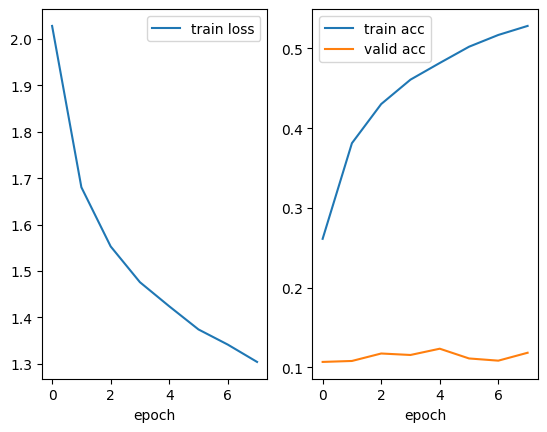

Epoch 9/20: 100%|██████████| 351/351 [00:31<00:00, 11.17it/s]


Epoch 9/20: train loss=1.280, train acc=0.539, valid acc=0.107


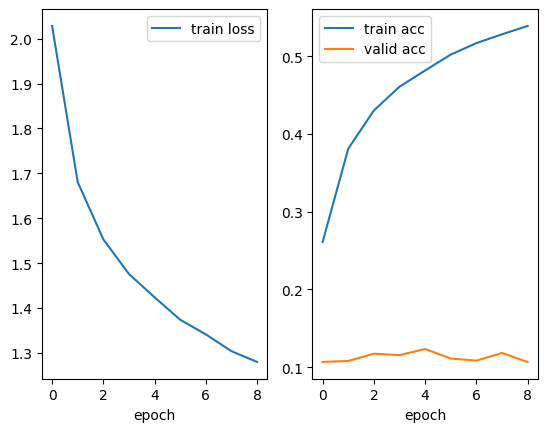

Epoch 10/20: 100%|██████████| 351/351 [00:31<00:00, 11.22it/s]


Epoch 10/20: train loss=1.252, train acc=0.549, valid acc=0.095


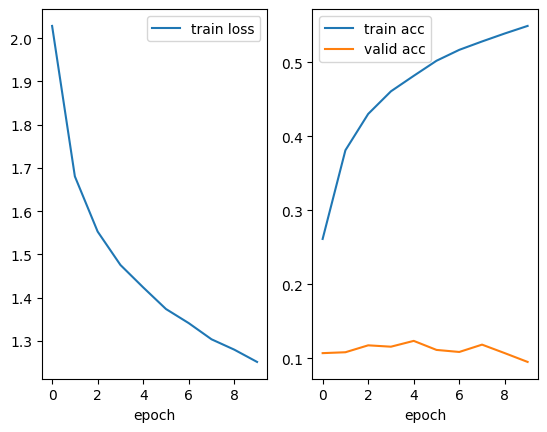

Epoch 11/20: 100%|██████████| 351/351 [00:31<00:00, 11.25it/s]


Epoch 11/20: train loss=1.229, train acc=0.558, valid acc=0.099


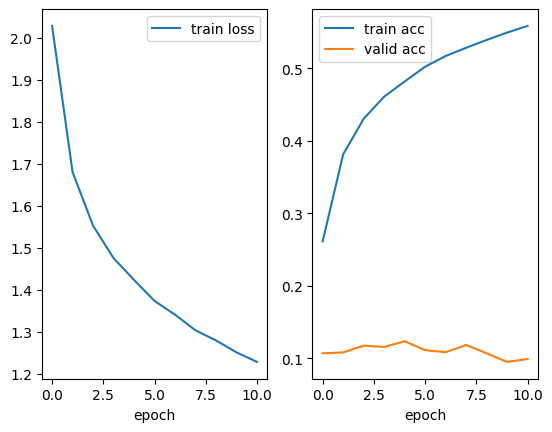

Epoch 12/20: 100%|██████████| 351/351 [00:31<00:00, 11.32it/s]


Epoch 12/20: train loss=1.200, train acc=0.570, valid acc=0.105


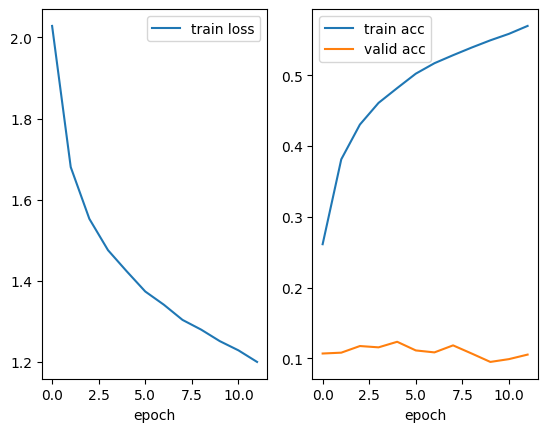

Epoch 13/20: 100%|██████████| 351/351 [00:30<00:00, 11.36it/s]


Epoch 13/20: train loss=1.182, train acc=0.577, valid acc=0.094


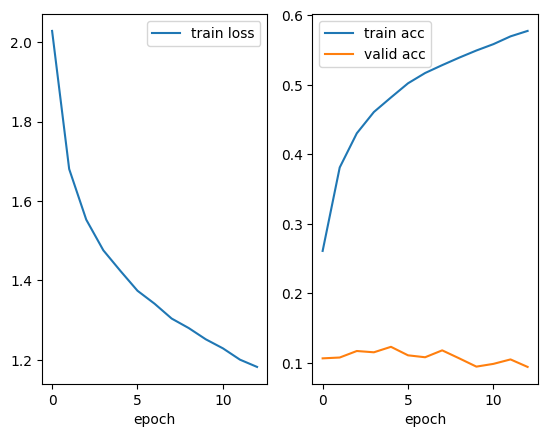

Epoch 14/20: 100%|██████████| 351/351 [00:30<00:00, 11.37it/s]


Epoch 14/20: train loss=1.160, train acc=0.586, valid acc=0.092


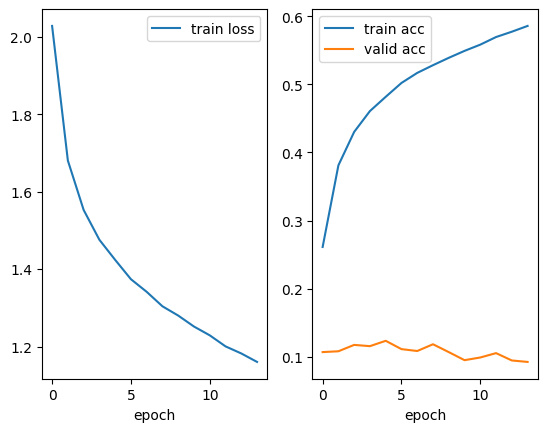

Epoch 15/20: 100%|██████████| 351/351 [00:30<00:00, 11.39it/s]


Epoch 15/20: train loss=1.142, train acc=0.594, valid acc=0.101


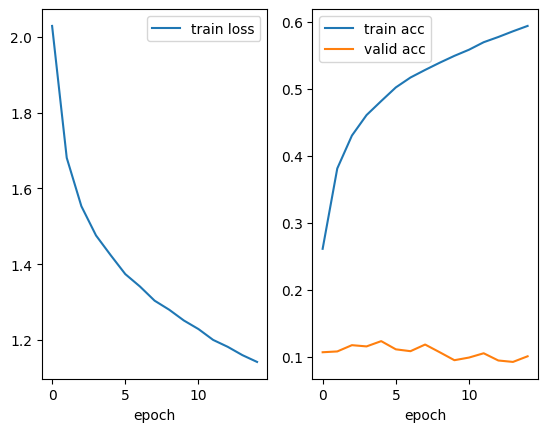

Epoch 16/20: 100%|██████████| 351/351 [00:31<00:00, 11.31it/s]


Epoch 16/20: train loss=1.131, train acc=0.598, valid acc=0.097


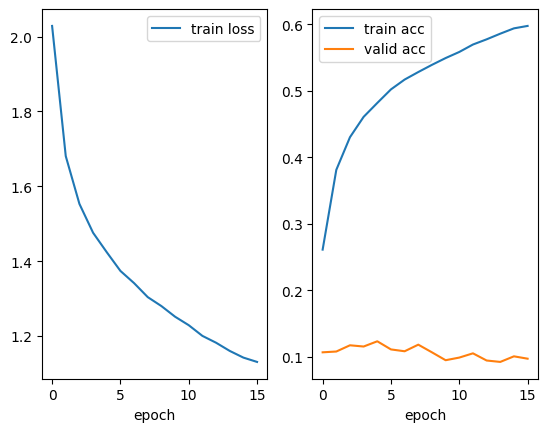

Epoch 17/20: 100%|██████████| 351/351 [00:30<00:00, 11.42it/s]


Epoch 17/20: train loss=1.113, train acc=0.601, valid acc=0.108


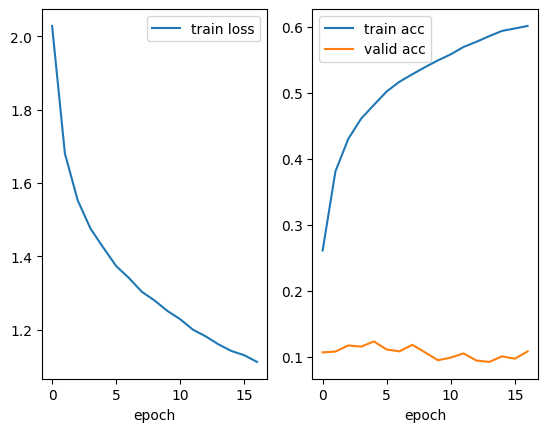

Epoch 18/20: 100%|██████████| 351/351 [00:30<00:00, 11.33it/s]


Epoch 18/20: train loss=1.095, train acc=0.609, valid acc=0.097


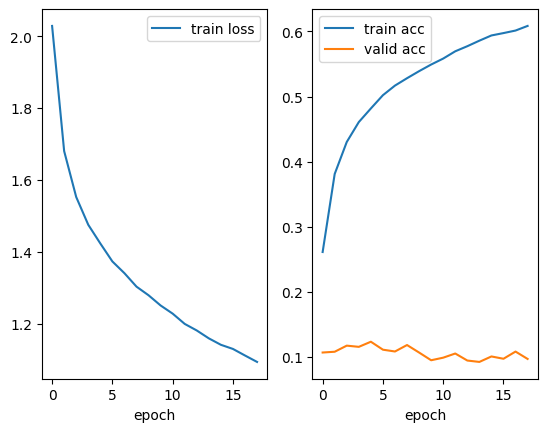

Epoch 19/20: 100%|██████████| 351/351 [00:31<00:00, 11.11it/s]


Epoch 19/20: train loss=1.088, train acc=0.611, valid acc=0.103


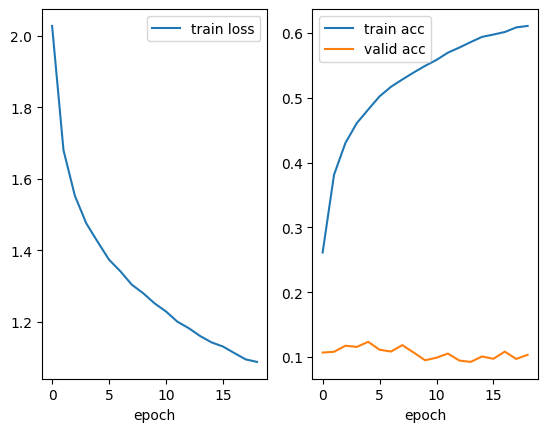

Epoch 20/20: 100%|██████████| 351/351 [00:31<00:00, 11.28it/s]


Epoch 20/20: train loss=1.067, train acc=0.620, valid acc=0.094


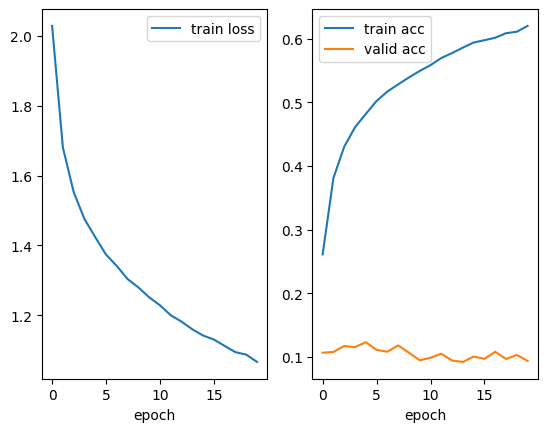

333.3 examples/sec on [device(type='cuda', index=0)]


In [13]:
def try_all_gpus():
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]
devices, num_epochs, lr, wd = try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9,get_net()
train(net, train_iter, test_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

对测试集进行分类并提交结果

In [ ]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X,_ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x:str(x))
df = pd.DataFrame({'id': sorted_ids, 'labels': preds})
df['labels'] = df['labels'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)